Objective: build a model that predict the breakdown by appliances (app version 2 - model step 1)

# 0. Import

In [8]:
%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import numpy as np
import datetime as dt
import time
import os
import pickle

from colorama import Fore, Style
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from joblib import dump, load

from decipherer.ml_logic.registry import save_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# environment variables
LOCAL_REGISTRY_PATH = "../training_outputs"

# prerequisite: having a "training_outputs" folder at the root of the project
#! tree ../training_outputs

# 1. Compute % breakdown for each room
* Kitchen: Oven, microwave and dishwasher
* Laundry room: Washing-machine, tumble-drier, fridge and light
* Heating room: Water-heater and AC

## 1.1. Kitchen: oven, microwave and dishwasher

### 1.1.1 Dishwasher

In [10]:
dishwasher_data = pd.read_csv('../data/appliances/dishwasher_53.csv',
                             parse_dates={'dt' : ['timestamp']}, infer_datetime_format=True, 
                             index_col='dt')

dishwasher_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592001 entries, 2021-01-18 00:51:25+00:00 to 2021-02-17 00:51:25+00:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 39.6 MB


In [11]:
print(dishwasher_data.isnull().sum())

power    0
dtype: int64


<AxesSubplot: xlabel='dt'>

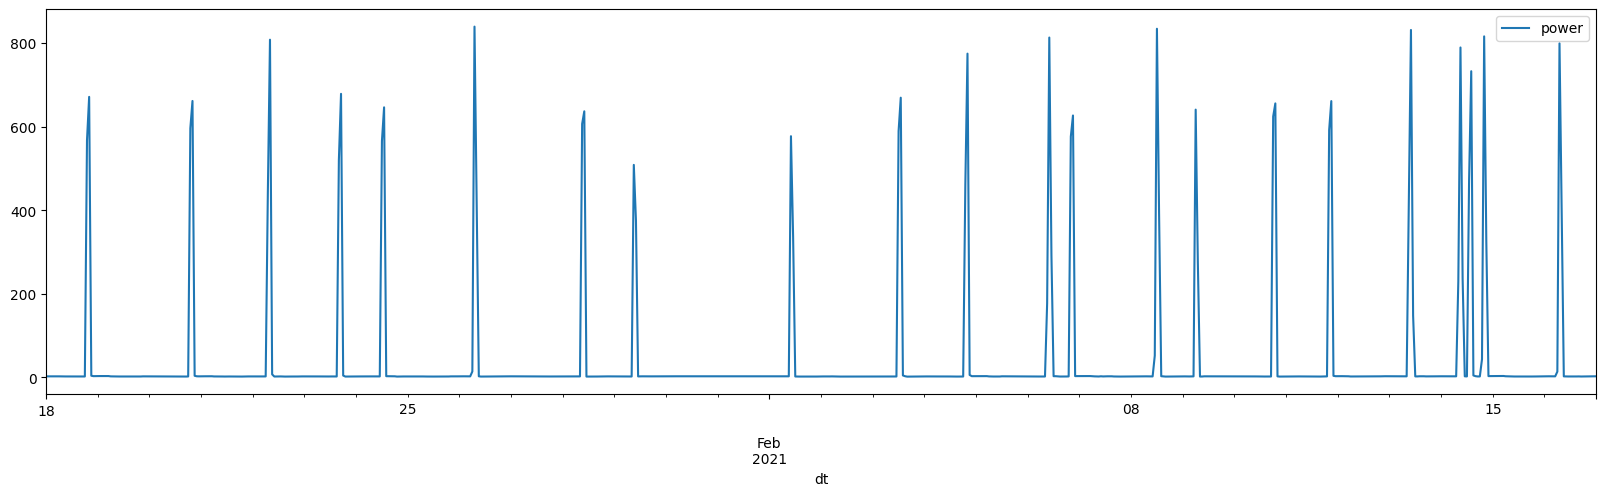

In [12]:
dishwasher_data.resample('h').mean().plot(figsize=(20,5))

<AxesSubplot: xlabel='dt'>

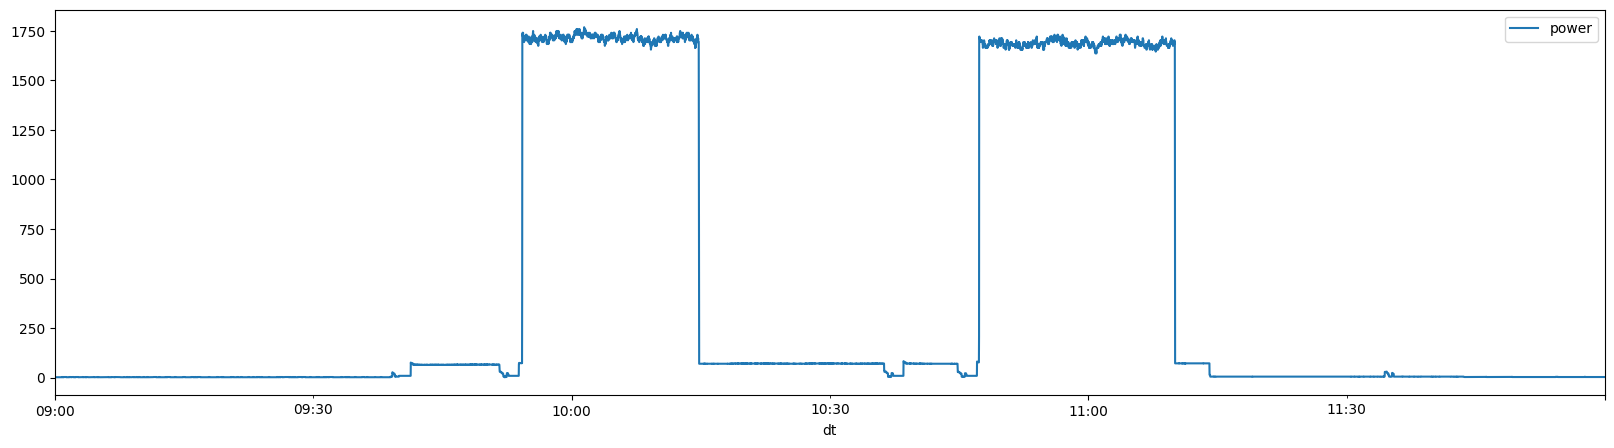

In [13]:
dishwasher_subdata = dishwasher_data[
    (dishwasher_data.index >= "2021-02-06 09:00:00") &
    (dishwasher_data.index < "2021-02-06 12:00:00")
].copy()

dishwasher_subdata.plot(figsize=(20,5))

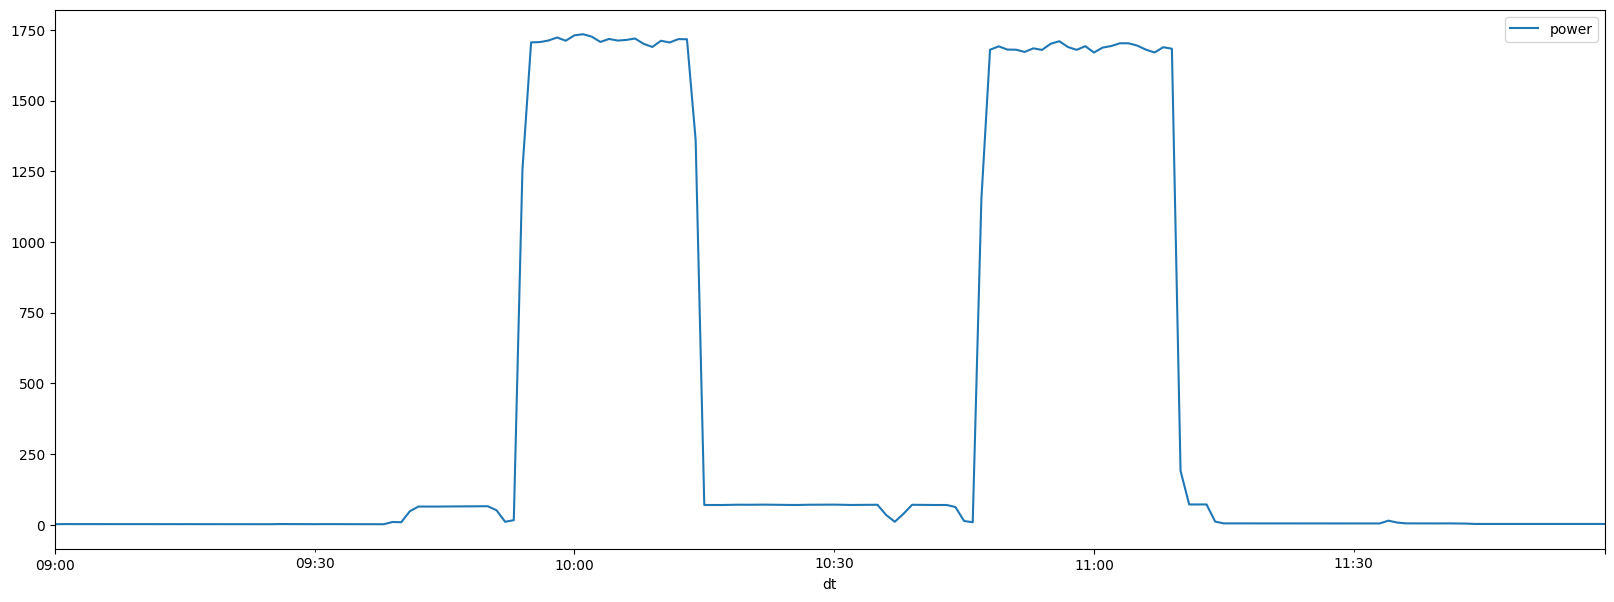

In [14]:
dishwasher_subdata = dishwasher_data[
    (dishwasher_data.index >= "2021-02-06 09:00:00") &
    (dishwasher_data.index < "2021-02-06 12:00:00")
].resample('T').mean().plot(figsize=(20,7))

In [15]:
# Converting power to energy: E[Wh] = P[W] * dt[h] --> E = P * 1/(60*60)
energy_wh = dishwasher_data / 3600

# Calculating the global consumption
global_consumption = float(energy_wh.sum())
print('Global consumption [Wh]:', global_consumption)

# Get the length of the dataset
days = len(dishwasher_data.resample('D'))
print('days nb:', days)

# Average consumption per day
dishwasher_daily_consumption = global_consumption / days
print('Average daily consumption [Wh]:', dishwasher_daily_consumption)

Global consumption [Wh]: 28145.428592592598
days nb: 31
Average daily consumption [Wh]: 907.9170513739548


### 1.1.2. Microwave

In [16]:
microwave_data = pd.read_csv('../data/appliances/micro_wave_oven_147.csv',
                             parse_dates={'dt' : ['timestamp']}, infer_datetime_format=True, 
                             index_col='dt')

microwave_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592001 entries, 2021-02-15 14:26:18+00:00 to 2021-03-17 14:26:18+00:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 39.6 MB


In [17]:
print(microwave_data.isnull().sum())

power    0
dtype: int64


<AxesSubplot: xlabel='dt'>

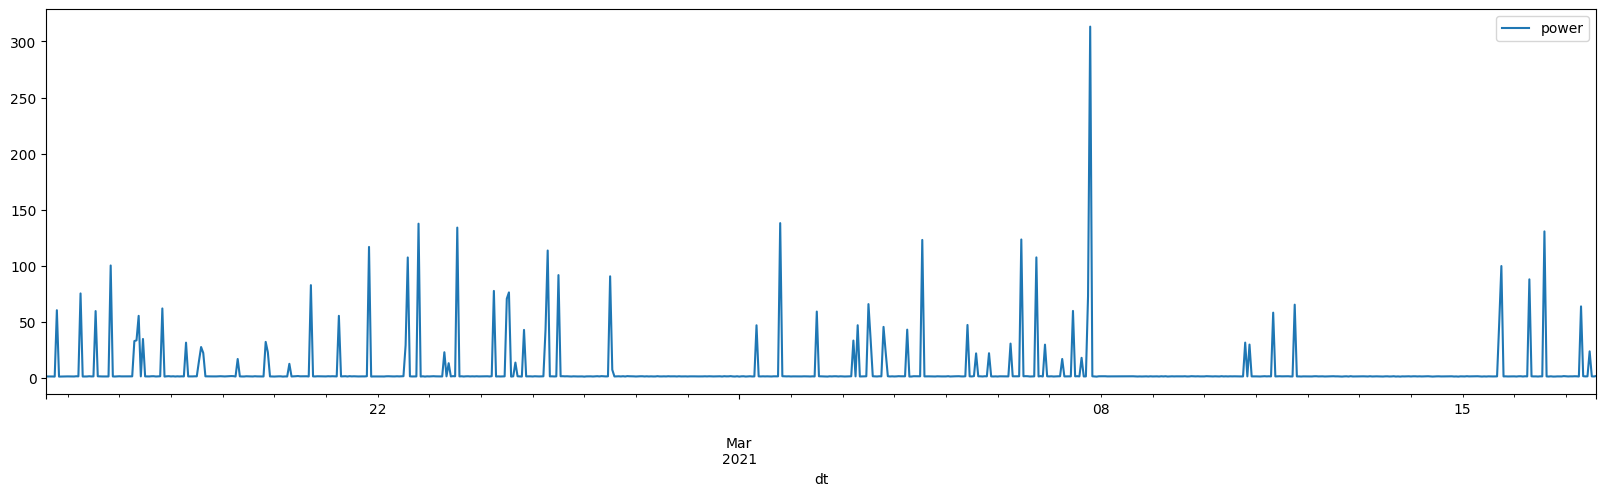

In [18]:
microwave_data.resample('h').mean().plot(figsize=(20,5))

<AxesSubplot: xlabel='dt'>

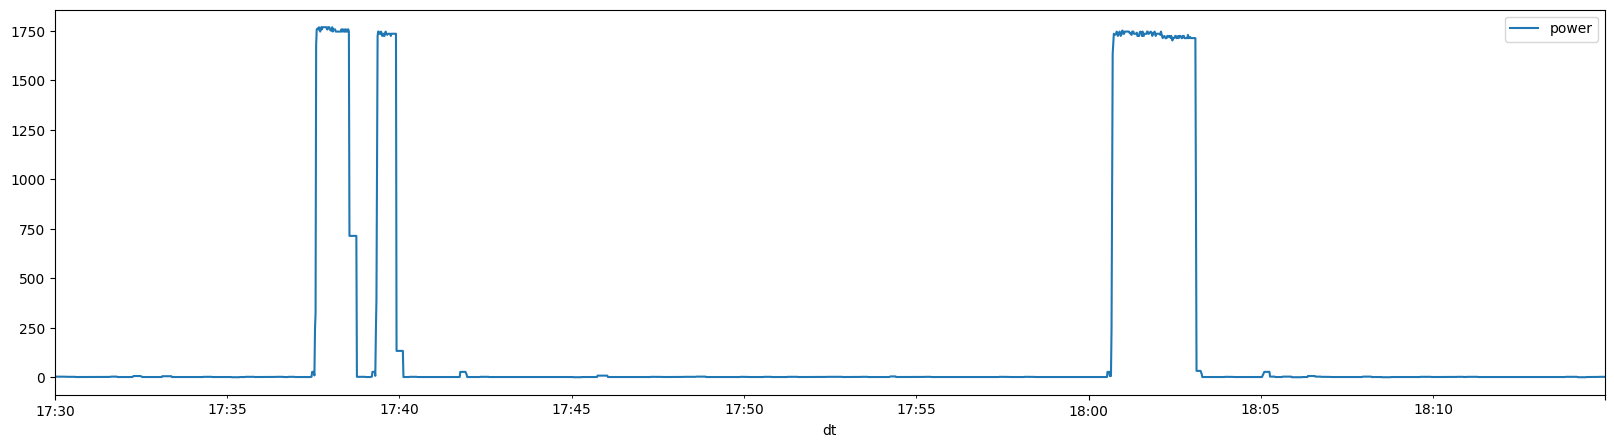

In [19]:
microwave_data[
    (microwave_data.index >= "2021-03-15 17:30:00") & 
    (microwave_data.index < "2021-03-15 18:15:00")
].plot(figsize=(20,5))

In [20]:
# Converting power to energy: E[Wh] = P[W] * dt[h] --> E = P * 1/(60*60)
energy_wh = microwave_data / 3600

# Calculating the global consumption
global_consumption = float(energy_wh.sum())
print('Global consumption [Wh]:', global_consumption)

# Get the length of the dataset
days = len(dishwasher_data.resample('D'))
print('days nb:', days)

# Average consumption per day
microwave_daily_consumption = global_consumption / days
print('Average daily consumption [Wh]:', microwave_daily_consumption)

Global consumption [Wh]: 5151.104062499995
days nb: 31
Average daily consumption [Wh]: 166.1646471774192


### 1.1.3. Oven

In [21]:
# Average consumption per day --> we need more data
# source: https://news.energysage.com/how-many-watts-does-an-electric-oven-and-stove-use/
oven_daily_consumption = 1022000 / 365
print('Average daily consumption [Wh]:', oven_daily_consumption)

Average daily consumption [Wh]: 2800.0


### 1.1.4 All together

In [22]:
total_consumption = dishwasher_daily_consumption + microwave_daily_consumption + oven_daily_consumption

dishwasher_pct = dishwasher_daily_consumption / total_consumption
microwave_pct = microwave_daily_consumption / total_consumption
oven_pct = oven_daily_consumption / total_consumption

kitchen_appliances = pd.DataFrame({
    'daily_pct': [dishwasher_pct, microwave_pct, oven_pct]
}, index=['dishwasher', 'microwave', 'oven'])

kitchen_appliances = dict(dishwasher = dishwasher_pct,
                          microwave = microwave_pct,
                          oven = oven_pct)

kitchen_appliances

{'dishwasher': 0.23435671264068852,
 'microwave': 0.04289136371067052,
 'oven': 0.722751923648641}

# 2. Build a pipeline to predict aplliances breakdown

In [23]:
# Example of data that we receive when the API is called
X = pd.read_csv('../data/input_datasets/y_pred_2008.csv',
                parse_dates={'dt' : ['datetime']}, infer_datetime_format=True)

X = X[['dt', 'sub_metering_1']]
X.columns = ['date_time', 'kitchen']

selected_appliances = ['dishwasher', 'microwave', 'oven']

X

,date_time,kitchen
0,2008-02-17 09:49:00,0.0
1,2008-04-21 11:27:00,0.0
2,2008-01-19 12:42:00,37.6
3,2008-11-14 12:39:00,0.1
4,2008-08-25 19:06:00,0.0
...,...,...
158107,2008-11-28 01:53:00,0.0
158108,2008-09-27 07:41:00,0.2
158109,2008-07-06 06:41:00,0.0
158110,2008-07-04 03:08:00,0.0


In [24]:
# # Building a model that realise step 1

# '''MODEL FOR V2 (APPLIANCE LEVEL) - STEP 1: USING CONSTANT PERCENTAGES'''
# class ApplianceEstimator(BaseEstimator):
    
#     def __init__(self, appliances_pct):
#         self.appliances_pct = appliances_pct
      
#     def predict(self, X):
        
#         y = X[['date_time']]
        
#         for appliance, pct in self.appliances_pct.items():
#            y[appliance] = X.iloc[:, 1] * pct
                
#         return y

In [25]:
# Wrap the model in a pipeline to keep the same format than before (v1)
kitchen_pipeline = Pipeline([('preparator', ApplianceEstimator(appliances_pct=kitchen_appliances))])
kitchen_pipeline

Pipeline(steps=[('preparator',
                 ApplianceEstimator(appliances_pct={'dishwasher': 0.23435671264068852,
                                                    'microwave': 0.04289136371067052,
                                                    'oven': 0.722751923648641}))])

In [26]:
# Try to predict using the pipeline (to test) (no need to be fitted --> stateless)
y_pred = kitchen_pipeline.predict(X)
y_pred

,date_time,dishwasher,microwave,oven
0,2008-02-17 09:49:00,0.000000,0.000000,0.000000
1,2008-04-21 11:27:00,0.000000,0.000000,0.000000
2,2008-01-19 12:42:00,8.811812,1.612715,27.175472
3,2008-11-14 12:39:00,0.023436,0.004289,0.072275
4,2008-08-25 19:06:00,0.000000,0.000000,0.000000
...,...,...,...,...
158107,2008-11-28 01:53:00,0.000000,0.000000,0.000000
158108,2008-09-27 07:41:00,0.046871,0.008578,0.144550
158109,2008-07-06 06:41:00,0.000000,0.000000,0.000000
158110,2008-07-04 03:08:00,0.000000,0.000000,0.000000


In [27]:
%%time

# Save it locally
params = dict(
    # Model parameters
    kitchen_appliances=kitchen_appliances,

    # Package behavior
    context="train appliance model step_1"
)

metrics = None # Irrelevant in step 1 (no y_true)

save_pipeline(kitchen_pipeline, params, metrics,
              pipeline_type='appliance', 
              local_registry_path=LOCAL_REGISTRY_PATH)


Save pipeline to local disk...

✅ data saved locally
CPU times: user 2.38 ms, sys: 237 µs, total: 2.61 ms
Wall time: 1.69 ms
